# Stabilityai/Japanese Stable VLM

「Japanese Stable VLM」は、日本語向けの画像言語モデルで、画像に対する説明生成や質問回答が可能です。商用利用が許可されており、「Japanese Stable LM Instruct Gamma 7B」を基にしています。最新のLLaVA-1.5 モデル構造を採用し、「タグ条件付きキャプショニング」機能を備えています。開発元の詳細は示されていませんが、高度な画像と言語の統合能力が特徴です。
- https://huggingface.co/stabilityai/japanese-stable-vlm

以下のリンクから登録が必要\
https://huggingface.co/stabilityai/japanese-stable-vlm

<a href="https://colab.research.google.com/github/fuyu-quant/data-science-wiki/blob/main/multimodal/text_to_image/stabilityai_japanese-stable-vlm.ipynb" target="_blank" rel="noopener noreferrer"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install diffusers==0.23.1
!pip install transformers==4.35.2
!pip install accelerate==0.24.1
!pip install sentencepiece==0.1.99

In [2]:
!git config --global credential.helper store

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
Your token has been saved in your conf

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForVision2Seq, AutoImageProcessor
from PIL import Image
import requests

device = "cuda" if torch.cuda.is_available() else "cpu"

### データの用意

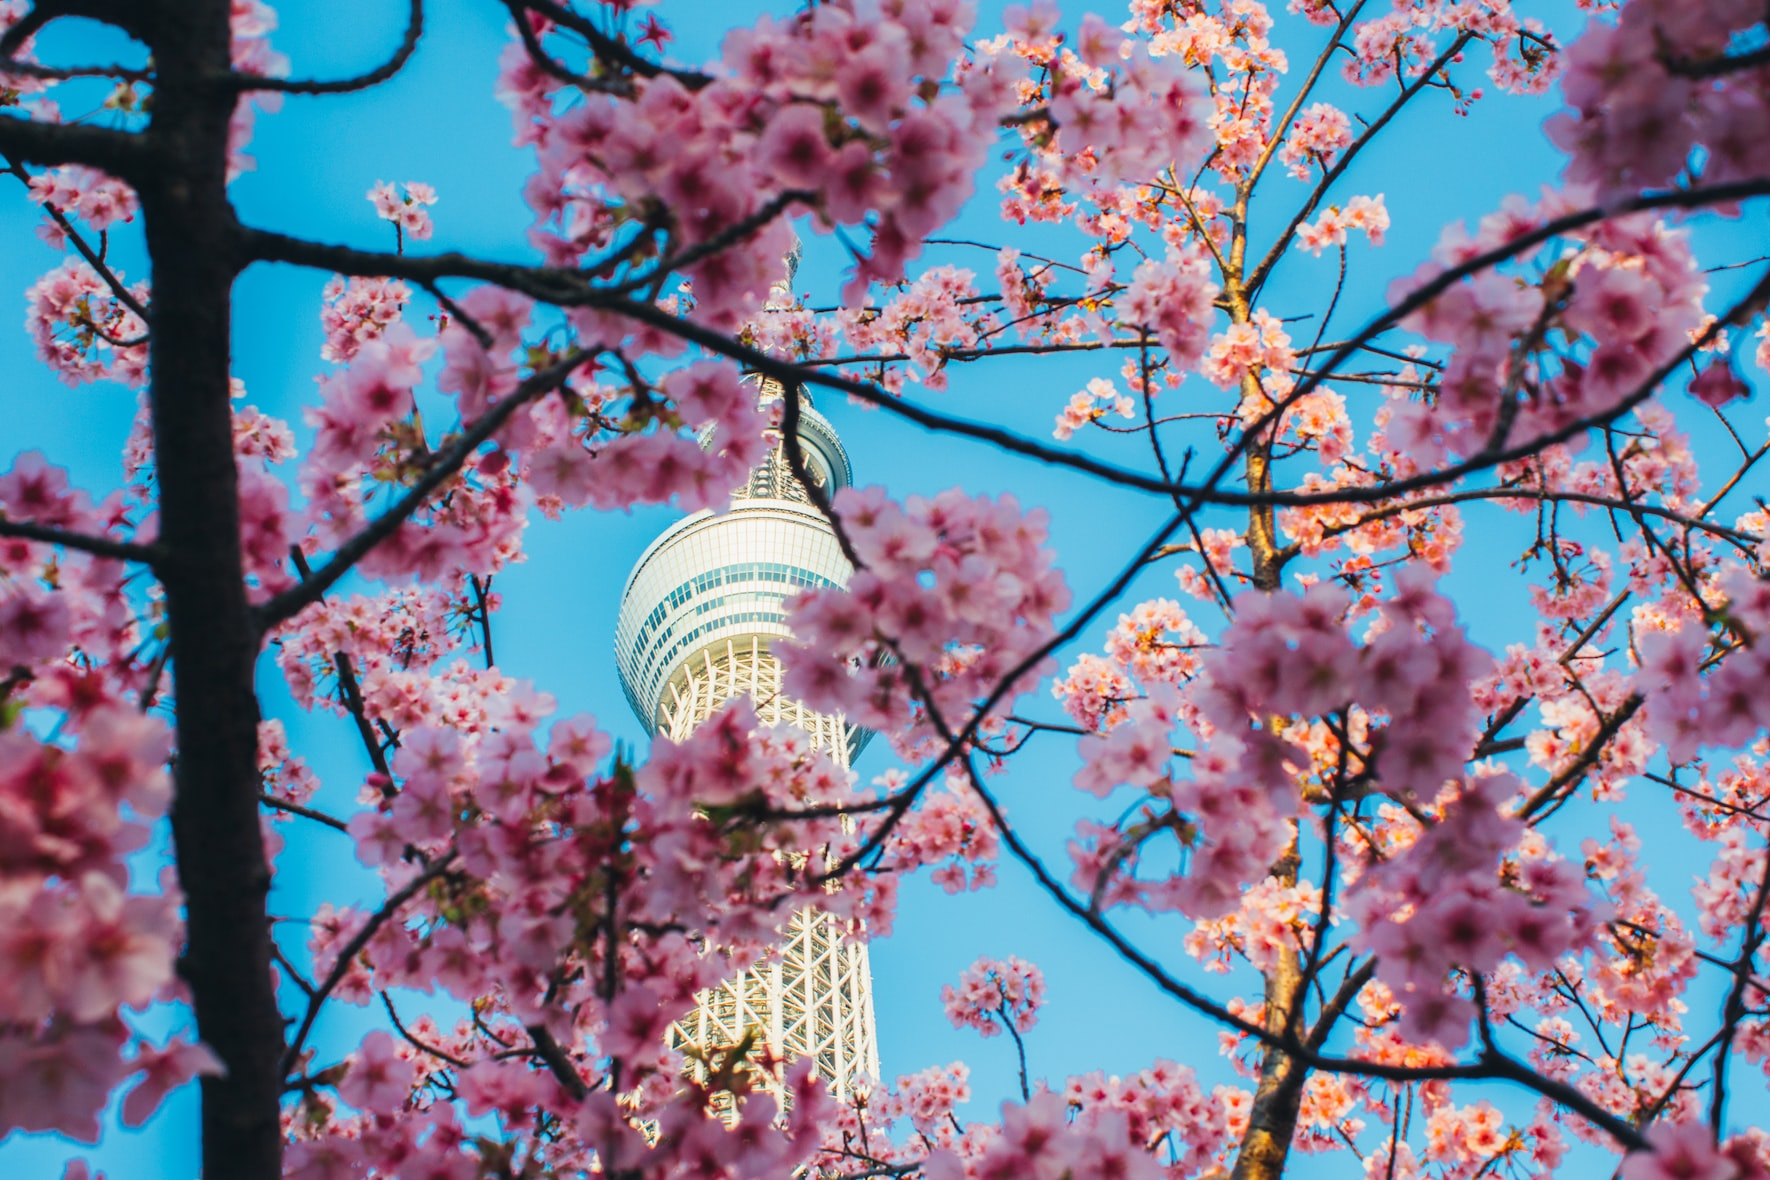

In [5]:
url = "https://images.unsplash.com/photo-1582538885592-e70a5d7ab3d3?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1770&q=80"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

In [ ]:
model = AutoModelForVision2Seq.from_pretrained("stabilityai/japanese-stable-vlm", trust_remote_code=True)
processor = AutoImageProcessor.from_pretrained("stabilityai/japanese-stable-vlm")
tokenizer = AutoTokenizer.from_pretrained("stabilityai/japanese-stable-vlm")
model.to(device)

In [8]:
TASK2INSTRUCTION = {
    "caption": "画像を詳細に述べてください。",
    "tag": "与えられた単語を使って、画像を詳細に述べてください。",
    "vqa": "与えられた画像を下に、質問に答えてください。",
}


def build_prompt(task="caption", input=None, sep="\n\n### "):
    assert (
        task in TASK2INSTRUCTION
    ), f"Please choose from {list(TASK2INSTRUCTION.keys())}"
    if task in ["tag", "vqa"]:
        assert input is not None, "Please fill in `input`!"
        if task == "tag" and isinstance(input, list):
            input = "、".join(input)
    else:
        assert input is None, f"`{task}` mode doesn't support to input questions"
    sys_msg = "以下は、タスクを説明する指示と、文脈のある入力の組み合わせです。要求を適切に満たす応答を書きなさい。"
    p = sys_msg
    roles = ["指示", "応答"]
    instruction = TASK2INSTRUCTION[task]
    msgs = [": \n" + instruction, ": \n"]
    if input:
        roles.insert(1, "入力")
        msgs.insert(1, ": \n" + input)
    for role, msg in zip(roles, msgs):
        p += sep + role + msg
    return p

prompt = build_prompt(task="caption")

In [9]:
prompt = build_prompt(task="caption")

inputs = processor(images=image, return_tensors="pt")
text_encoding = tokenizer(prompt, add_special_tokens=False, return_tensors="pt")
inputs.update(text_encoding)

outputs = model.generate(
    **inputs.to(device, dtype=model.dtype),
    do_sample=False,
    num_beams=5,
    max_new_tokens=128,
    min_length=1,
    repetition_penalty=1.5,
)
generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


桜越しの東京スカイツリー


In [10]:
prompt = build_prompt(task="tag", input=["河津桜", "青空"])

inputs = processor(images=image, return_tensors="pt")
text_encoding = tokenizer(prompt, add_special_tokens=False, return_tensors="pt")
inputs.update(text_encoding)

outputs = model.generate(
    **inputs.to(device, dtype=model.dtype),
    do_sample=False,
    num_beams=5,
    max_new_tokens=128,
    min_length=1,
    repetition_penalty=1.5,
)
generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


青空に映える河津桜と東京スカイツリー


In [11]:
prompt = build_prompt(task="vqa", input="季節はいつですか？")

inputs = processor(images=image, return_tensors="pt")
text_encoding = tokenizer(prompt, add_special_tokens=False, return_tensors="pt")
inputs.update(text_encoding)

# generate
outputs = model.generate(
    **inputs.to(device, dtype=model.dtype),
    do_sample=False,
    num_beams=5,
    max_new_tokens=128,
    min_length=1,
    repetition_penalty=1.5,
)
generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


春
